In [1]:
import shapefile
import matplotlib.pyplot as plt
from math import sqrt
import random
import utm
%matplotlib inline

In [2]:
class Node:
    def __init__(self,x,y,name):
        self.x = x
        self.y = y
        self.name = name
    def displayNodeDetails(self):
        print("\nName : ",self.name,"\nX : ",self.x,"\nY : ",self.y)

class Edge:
    def __init__(self,name1,name2,cost):
        self.node1 = name1
        self.node2 = name2
        self.cost = cost
    def displayEdgeDetails(self):
        print("\nNode1 : ",self.node1,"\nNode2 : ",self.node2,"\nCost : ",self.cost)

class Graph:
    def __init__(self):
        self.visited = []
        self.selected = []
        self.nodes = []
        self.edges = []
    def addNode(self,x,y,name):
        temp = Node(x,y,name)
        self.nodes.append(temp)
    def addEdge(self,name1,name2,cost):
        temp = Edge(name1,name2,cost)
        self.edges.append(temp)
    def getcost(self,edge):
        return edge.cost
    def sortEdges(self):
        self.edges = sorted(self.edges, key=self.getcost)
    def kruskal(self):
        i = 0
        while(len(self.visited) != len(self.nodes)):
            edge = self.edges[i]
            if(edge.node1 not in self.visited or edge.node2 not in self.visited):
                self.selected.append(edge)
                if(edge.node1 not in self.visited): self.visited.append(edge.node1)
                if(edge.node2 not in self.visited): self.visited.append(edge.node2)
            i+=1

In [3]:
'''
First run g = Graph()
then run g.addNode() and g.addEdge() for ever node and edge resp
then run g.sortEdges()
then run g.kruskal()
get the selected edges from g.selected
'''

'\nFirst run g = Graph()\nthen run g.addNode() and g.addEdge() for ever node and edge resp\nthen run g.sortEdges()\nthen run g.kruskal()\nget the selected edges from g.selected\n'

In [4]:
allRoadPoints = []
allRoadTypes = []
allRoadLengths = []
newRoadPoints = []
intersections = []
cntx = 0

# fn to get points from a shape variable
def getVillagepoints(shpVar):
    return [shpVar.shape(i).points[0] for i in range(len(shpVar.shapes()))]

# fn to display any point given index
def displaypoints(points, tp = 1): 
    x = [pt[0] for pt in points]
    y = [pt[1] for pt in points]
    hnd = 0
    if(tp == 1):
        hnd, = plt.plot(x,y,'ro',label="Villages")
    else:
        hnd, = plt.plot(x,y,'ko',label="Intersections")
    return hnd
    
# fn to get fields and records of a shape variable
def getFieldsAndRecords(shpVar):
    return shpVar.fields, shpVar.records()

# fn to display all points of a road
def addRoadPoints(recIndex,rdShapes):
    global allRoadPoints
    print('%d Points of %d road' %(len(rdShapes.shape(recIndex).points),recIndex+1),rdShapes.shape(recIndex).points)
    allRoadPoints.append(rdShapes.shape(recIndex).points)
    
# plotting pts to see if they make a road
def plotRoadPoints(points, types, villCoords = None, intersections = None):
    i = 0
    plt.figure(figsize=(40,40))
    for l in points:
        x = [t[0] for t in l]
        y = [t[1] for t in l]
        tp = types[i]
        if(tp == 1): hnd1, = plt.plot(x,y,color='blue',label="Major Roads")
        elif(tp == 2): hnd2, = plt.plot(x,y,color='yellowgreen',label="Minor Roads")
        elif(tp == 3): hnd3, = plt.plot(x,y,color='coral',label="Muddy Roads")
        i += 1
    if(intersections != None): 
        hnd5 = displaypoints(intersections,0)
        hnd4 = displaypoints(villCoords,1)
        #plt.legend(handles=[hnd1, hnd2, hnd3, hnd4, hnd5],fontsize=20)
    else:
        hnd4 = displaypoints(villCoords,1)
        #plt.legend(handles=[hnd1, hnd2, hnd3, hnd4],fontsize=20)
    plt.axis('off')
    plt.savefig("final.png", bbox_inches="tight", pad_inches = 0)
    plt.show()
    
# fn to display road details given index 
def showroadDetails(rdFields, rdRec, rdShapes):
    for index in range(len(rdRec)):
        for i in range(len(rdFields)-1):
            if('Name' in rdFields[i+1][0]): 
                if('MR' in rdRec[index][i]):
                    allRoadTypes.append(1)
                elif('Minor' in rdRec[index][i]):
                    allRoadTypes.append(2)
                else:
                    allRoadTypes.append(3)
            print(rdFields[i+1][0]," : ",rdRec[index][i])
            if('Shape_Leng' in rdFields[i+1][0]):
                allRoadLengths.append(rdRec[index][i])
        addRoadPoints(index,rdShapes)
        print("=================================================================================================")   

# fn to find the distances of every village from every single point in each road
def findDistances(villCoords):
    allVillagesDist = {}
    i = 1
    for vlg in villCoords:
        d = []
        vx = vlg[0]
        vy = vlg[1]
        for rd in allRoadPoints:
            dist = []
            for rdpt in rd:
                rx = rdpt[0]
                ry = rdpt[1]
                dist.append(sqrt((ry-vy)**2+(rx-vx)**2))
            d.append(dist)
        allVillagesDist[i] = d
        i+=1
    return allVillagesDist

# fn to find n closest roads to a village
def findClosestn(road, allVillagesDist, rdRec, n=5):
    villMins = {}
    _,rdRecCopy = getFieldsAndRecords(road)

    for key in allVillagesDist.keys():
        minDist = []
        d = allVillagesDist[key]
        for dist in d:
            minDist.append(min(dist))
        temp = []
        for k in range(n):
            minVal = min(minDist)
            minValIndex = minDist.index(minVal)
            l = [minVal, rdRec.index(rdRecCopy[minValIndex]), rdRecCopy[minValIndex][4]]
            if 'MR' in rdRecCopy[minValIndex][0]:
                l.append(1)
            elif 'Minor' in rdRecCopy[minValIndex][0]:
                l.append(2)
            else:
                l.append(3)
            temp.append(l)
            rdRecCopy.remove(rdRecCopy[minValIndex])
            minDist.remove(minVal)
        villMins[key] = temp
        _,rdRecCopy = getFieldsAndRecords(road)
    return villMins

# fn to plot closest n roads with their villaes
def plotClosestn(rdShape, villMin, points):
    selectedRoads = []
    selectedTypes = []
    for k in villMins.keys():
        sl = []
        indices = [t[1] for t in villMins[k]]
        types = [t[3] for t in villMins[k]]
        for i in indices:
            sl.append(road.shape(i).points)
        selectedRoads.append(sl)
        selectedTypes.append(types)
    i = 1
    plt.figure(figsize=(20,20))
    for vRoads in selectedRoads:
        for rd in vRoads:
            x = [t[0] for t in rd]
            y = [t[1] for t in rd]
            rand = random.randint(100000,999999)
            hnd1, = plt.plot(x,y,color='#'+str(rand), label="roads")
            hnd2, = plt.plot(villCoords[i-1][0], villCoords[i-1][1], 'ko', label="Villages")
        plt.legend(handles=[hnd1, hnd2])
        i += 1
    plt.show()

# fn to find intersection point
def findIntersection(p1, p2, p3, p4):
    a1 = p2[1] - p1[1]
    b1 = p1[0] - p2[0]
    c1 = a1*p1[0] + b1*p1[1]
    a2 = p4[1] - p3[1]
    b2 = p3[0] - p4[0]
    c2 = a2*p3[0] + b2*p3[1]
    
    det = a1*b2 - a2*b1
    if(det == 0):
        return None
    else:
        x = (b2*c1 - b1* c2)/det
        y = (a1*c2 - a2*c1)/det
        if(x >= min(p1[0],p2[0]) and x <= max(p1[0],p2[0]) and y >= min(p1[1],p2[1]) and y <= max(p1[1],p2[1]) 
          and x >= min(p3[0],p4[0]) and x <= max(p3[0],p4[0]) and y >= min(p3[1],p4[1]) and y <= max(p3[1],p4[1])): 
            return (x,y)
        else:
            return None

#fn to check if a point is on the equation of line
def solvesEquation(chkpt, p1, p2):
    a1 = p2[1] - p1[1]
    b1 = p1[0] - p2[0]
    c1 = a1*p1[0] + b1*p1[1]
    if(c1 == (a1*chkpt[0]+b1*chkpt[1])):
        return True
    else: 
        return False

# fn to plot intersections
def plotIntersections(roadp, roadt, villCoords=None):
    global intersections, newRoadPoints
    for rd1 in roadp:
        prevCnt = len(intersections)
        for j in range(len(rd1)-1):
            p1 = rd1[j]
            p2 = rd1[j+1]
            for rd2 in roadp:
                for l in range(len(rd2)-1):
                    p3 = rd2[l]
                    p4 = rd2[l+1]
                    val = findIntersection(p1, p2, p3, p4)
                    if(val!=None): 
                        intersections.append(val)
                    if(rd1 != rd2):
                        if(p1 == p3 or p1 == p4 or solvesEquation(p1,p3,p4)): 
                            intersections.append(p1)
                        if(p2 == p3 or p2 == p4 or solvesEquation(p2,p3,p4)): 
                            intersections.append(p2)
        newRoadPoints.append(intersections[prevCnt:len(intersections)])
    print("\nIntersections found : ",len(set(intersections)))
    plotRoadPoints(roadp, roadt, villCoords=villCoords, intersections=set(intersections))
    
# fn to convert all the utm coordinates to lattitude longitude
def convertToLatLong(roadp=None, villp=None):
    if(roadp!=None):
        llPoints = []
        for rd in roadp:
            rdPoints = []
            for pt in rd:
                rdPoints.append(utm.to_latlon(pt[0],pt[1],44,'R'))
            llPoints.append(rdPoints)
        return llPoints
    else:
        llPoints = []
        for pt in villp:
            llPoints.append(utm.to_latlon(pt[0],pt[1],44,'R'))
        return llPoints

In [5]:
road = shapefile.Reader("../Data/Road_Network.shp")
vill = shapefile.Reader("../Data/Villages.shp")

In [6]:
villCoords = getVillagepoints(vill)

In [7]:
rdFields, rdRec = getFieldsAndRecords(road)

In [8]:
showroadDetails(rdFields, rdRec, road)

Name  :  MR1
PREFIX  :  Dharampur Chauk
PRE_Type  :  Chauk
SUFFIX  :  Race Course End
FULL_NAME  :  Race Course to Dharampur Road
Oneway  :  T
Shape_Leng  :  78.307448375
FT_SpeedLi  :  80
TF_SpeedLi  :  80
FT_Time  :  0.0587305862812
TF_Time  :  0.0587305862812
3 Points of 1 road [(216094.7971999999, 3356367.9661), (216083.13410000037, 3356324.9970999993), (216084.36180000007, 3356291.2357)]
Name  :  MR2
PREFIX  :  Dhrampur Chauk
PRE_Type  :  Chauk
SUFFIX  :  River End
FULL_NAME  :  Dharampur Road
Oneway  :  F
Shape_Leng  :  1622.69599276
FT_SpeedLi  :  80
TF_SpeedLi  :  80
FT_Time  :  1.21702199457
TF_Time  :  1.21702199457
43 Points of 2 road [(216084.36180000007, 3356291.2357), (216091.7279000003, 3356239.0591), (216092.9556, 3356217.5746), (216096.09190000035, 3356189.7958000004), (216097.2525000004, 3356179.5163000003), (216099.66949999984, 3356162.9042000007), (216099.20909999963, 3356147.2512), (216101.97140000015, 3356130.217), (216101.30420000013, 3356113.2015000004), (216101

TF_SpeedLi  :  40
FT_Time  :  0.151232059267
TF_Time  :  0.151232059267
7 Points of 108 road [(216695.37739999965, 3356011.9033000004), (216698.69450000022, 3356010.4475), (216731.96860000025, 3355995.8442), (216757.8925999999, 3355984.466600001), (216770.94990000036, 3355978.7359999996), (216777.49969999958, 3355975.8615000006), (216787.69880000036, 3355971.3852999993)]
Name  :  Street
PREFIX  :  strart End
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street45
Oneway  :  
Shape_Leng  :  69.2844224398
FT_SpeedLi  :  31
TF_SpeedLi  :  31
FT_Time  :  0.134098882142
TF_Time  :  0.134098882142
12 Points of 109 road [(216745.84200000018, 3355930.5288999993), (216737.54970000032, 3355911.8713000007), (216732.108, 3355910.5756), (216731.07139999978, 3355906.4295000006), (216725.3705000002, 3355905.3928999994), (216722.51999999955, 3355899.692), (216723.29739999957, 3355895.0275999997), (216720.96520000044, 3355891.3998000007), (216717.85560000036, 3355887.5128000006), (216714.74600000028, 3355884.

TF_Time  :  0.0831378154435
7 Points of 219 road [(217154.34609999973, 3356355.4112), (217171.2762000002, 3356347.118899999), (217175.42229999974, 3356344.354800001), (217180.60500000045, 3356340.899700001), (217183.7145999996, 3356338.1356000006), (217186.82419999968, 3356336.0626), (217193.38889999967, 3356331.9164000005)]
Name  :  Street
PREFIX  :  start end
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street401
Oneway  :  FT
Shape_Leng  :  72.8054433926
FT_SpeedLi  :  33
TF_SpeedLi  :  33
FT_Time  :  0.132373533441
TF_Time  :  0.132373533441
22 Points of 220 road [(217139.48919999972, 3356337.0990999993), (217151.23649999965, 3356327.424799999), (217153.30960000027, 3356323.9696999993), (217154.69159999955, 3356320.8600999992), (217156.0736999996, 3356318.4415000007), (217160.91079999972, 3356316.7139999997), (217164.0203999998, 3356317.0594999995), (217167.8211000003, 3356317.4049999993), (217169.20309999958, 3356320.1690999996), (217169.20309999958, 3356322.2421000004), (217170.239599

2 Points of 330 road [(217167.0990000004, 3355644.9681), (217156.50329999998, 3355632.5297)]
Name  :  Street
PREFIX  :  
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street246
Oneway  :  TF
Shape_Leng  :  21.6569070951
FT_SpeedLi  :  32
TF_SpeedLi  :  32
FT_Time  :  0.0406067008033
TF_Time  :  0.0406067008033
2 Points of 331 road [(217176.31259999983, 3355638.0579000004), (217186.90830000024, 3355656.945800001)]
Name  :  Street
PREFIX  :  
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street247
Oneway  :  
Shape_Leng  :  24.7998323047
FT_SpeedLi  :  32
TF_SpeedLi  :  32
FT_Time  :  0.0464996855713
TF_Time  :  0.0464996855713
2 Points of 332 road [(217266.64630000014, 3355749.0031000003), (217276.74110000022, 3355771.6554000005)]
Name  :  Street
PREFIX  :  
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street248
Oneway  :  
Shape_Leng  :  55.2655590857
FT_SpeedLi  :  32
TF_SpeedLi  :  32
FT_Time  :  0.103622923286
TF_Time  :  0.103622923286
2 Points of 333 road [(216960.36390000023, 3355709.1511000004),

Name  :  Street
PREFIX  :  
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street162
Oneway  :  
Shape_Leng  :  54.0973875971
FT_SpeedLi  :  29
TF_SpeedLi  :  29
FT_Time  :  0.111925629511
TF_Time  :  0.111925629511
8 Points of 442 road [(217131.5837000003, 3355560.6253999993), (217122.22929999977, 3355566.4581000004), (217118.12579999957, 3355569.0167999994), (217109.08169999998, 3355574.6559999995), (217102.21520000044, 3355578.9375), (217100.14219999965, 3355583.0835999995), (217100.83320000023, 3355587.5753000006), (217092.88650000002, 3355594.1400000006)]
Name  :  Street
PREFIX  :  
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street163
Oneway  :  
Shape_Leng  :  19.932125356
FT_SpeedLi  :  29
TF_SpeedLi  :  29
FT_Time  :  0.041238880047
TF_Time  :  0.041238880047
2 Points of 443 road [(217089.08579999954, 3355566.4990999997), (217100.14219999965, 3355583.0835999995)]
Name  :  Street
PREFIX  :  
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street164
Oneway  :  
Shape_Leng  :  19.0610259653
FT_Spee

PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street330
Oneway  :  TF
Shape_Leng  :  81.3417262787
FT_SpeedLi  :  24
TF_SpeedLi  :  24
FT_Time  :  0.203354315697
TF_Time  :  0.203354315697
7 Points of 539 road [(216040.26790000033, 3356221.2491999995), (216037.04310000036, 3356217.5637), (216028.2901999997, 3356219.8671000004), (216021.3799999999, 3356224.0132999998), (216002.8178000003, 3356187.2090000007), (216000.02639999986, 3356181.6742000002), (215994.66050000023, 3356171.0349000003)]
Name  :  Street
PREFIX  :  start end
PRE_Type  :  
SUFFIX  :  
FULL_NAME  :  Street331
Oneway  :  
Shape_Leng  :  55.5494271102
FT_SpeedLi  :  24
TF_SpeedLi  :  24
FT_Time  :  0.138873567776
TF_Time  :  0.138873567776
6 Points of 540 road [(216142.84119999968, 3356175.3056000005), (216138.39300000016, 3356170.1136000007), (216137.93230000045, 3356165.0461), (216134.70749999955, 3356162.2819999997), (216131.0220999997, 3356157.6752000004), (216099.20909999963, 3356147.2512)]
Name  :  Street
PREFIX  :  star

In [9]:
allVillagesDist = findDistances(villCoords)
villMins = findClosestn(road, allVillagesDist, rdRec, 4)
#plotClosestn(road, villMins, villCoords)

In [10]:
'''
Converting to lat-lon coordinates
'''
allRoadsLatLong = convertToLatLong(roadp=allRoadPoints)
allVillagesLatLong = convertToLatLong(villp=villCoords)

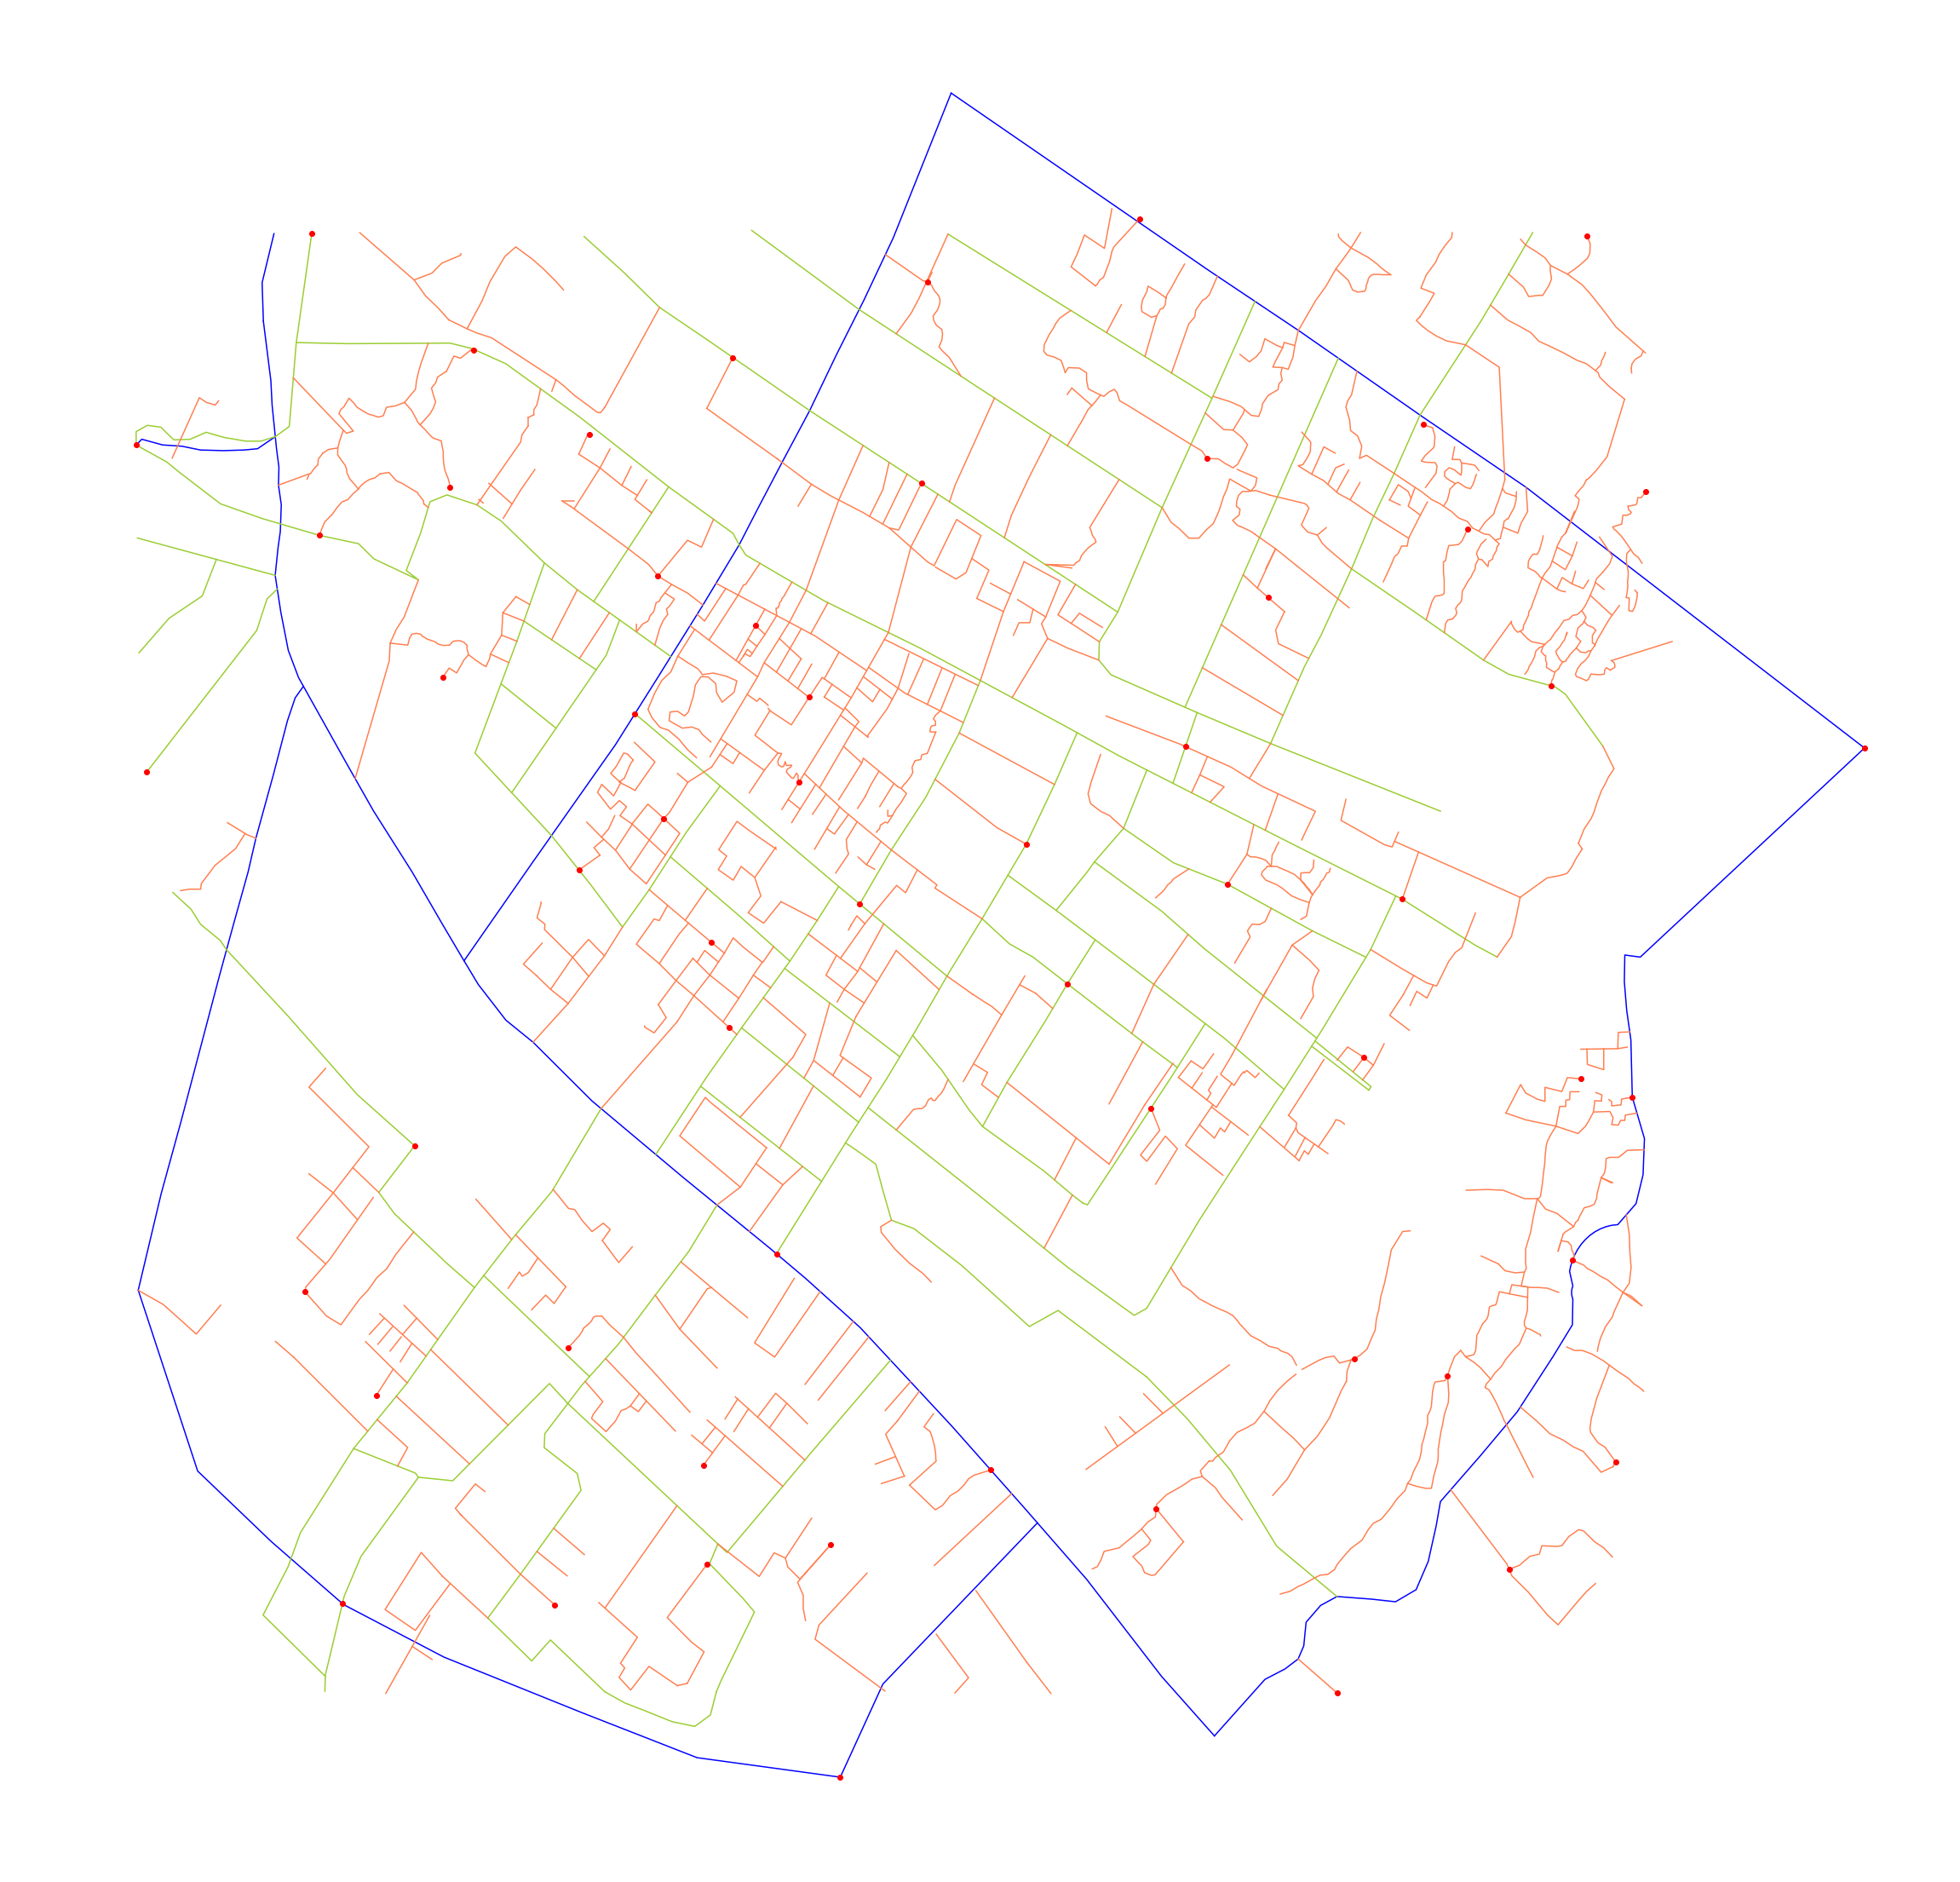

In [12]:
plotRoadPoints(allRoadPoints,allRoadTypes,villCoords)


Intersections found :  1030


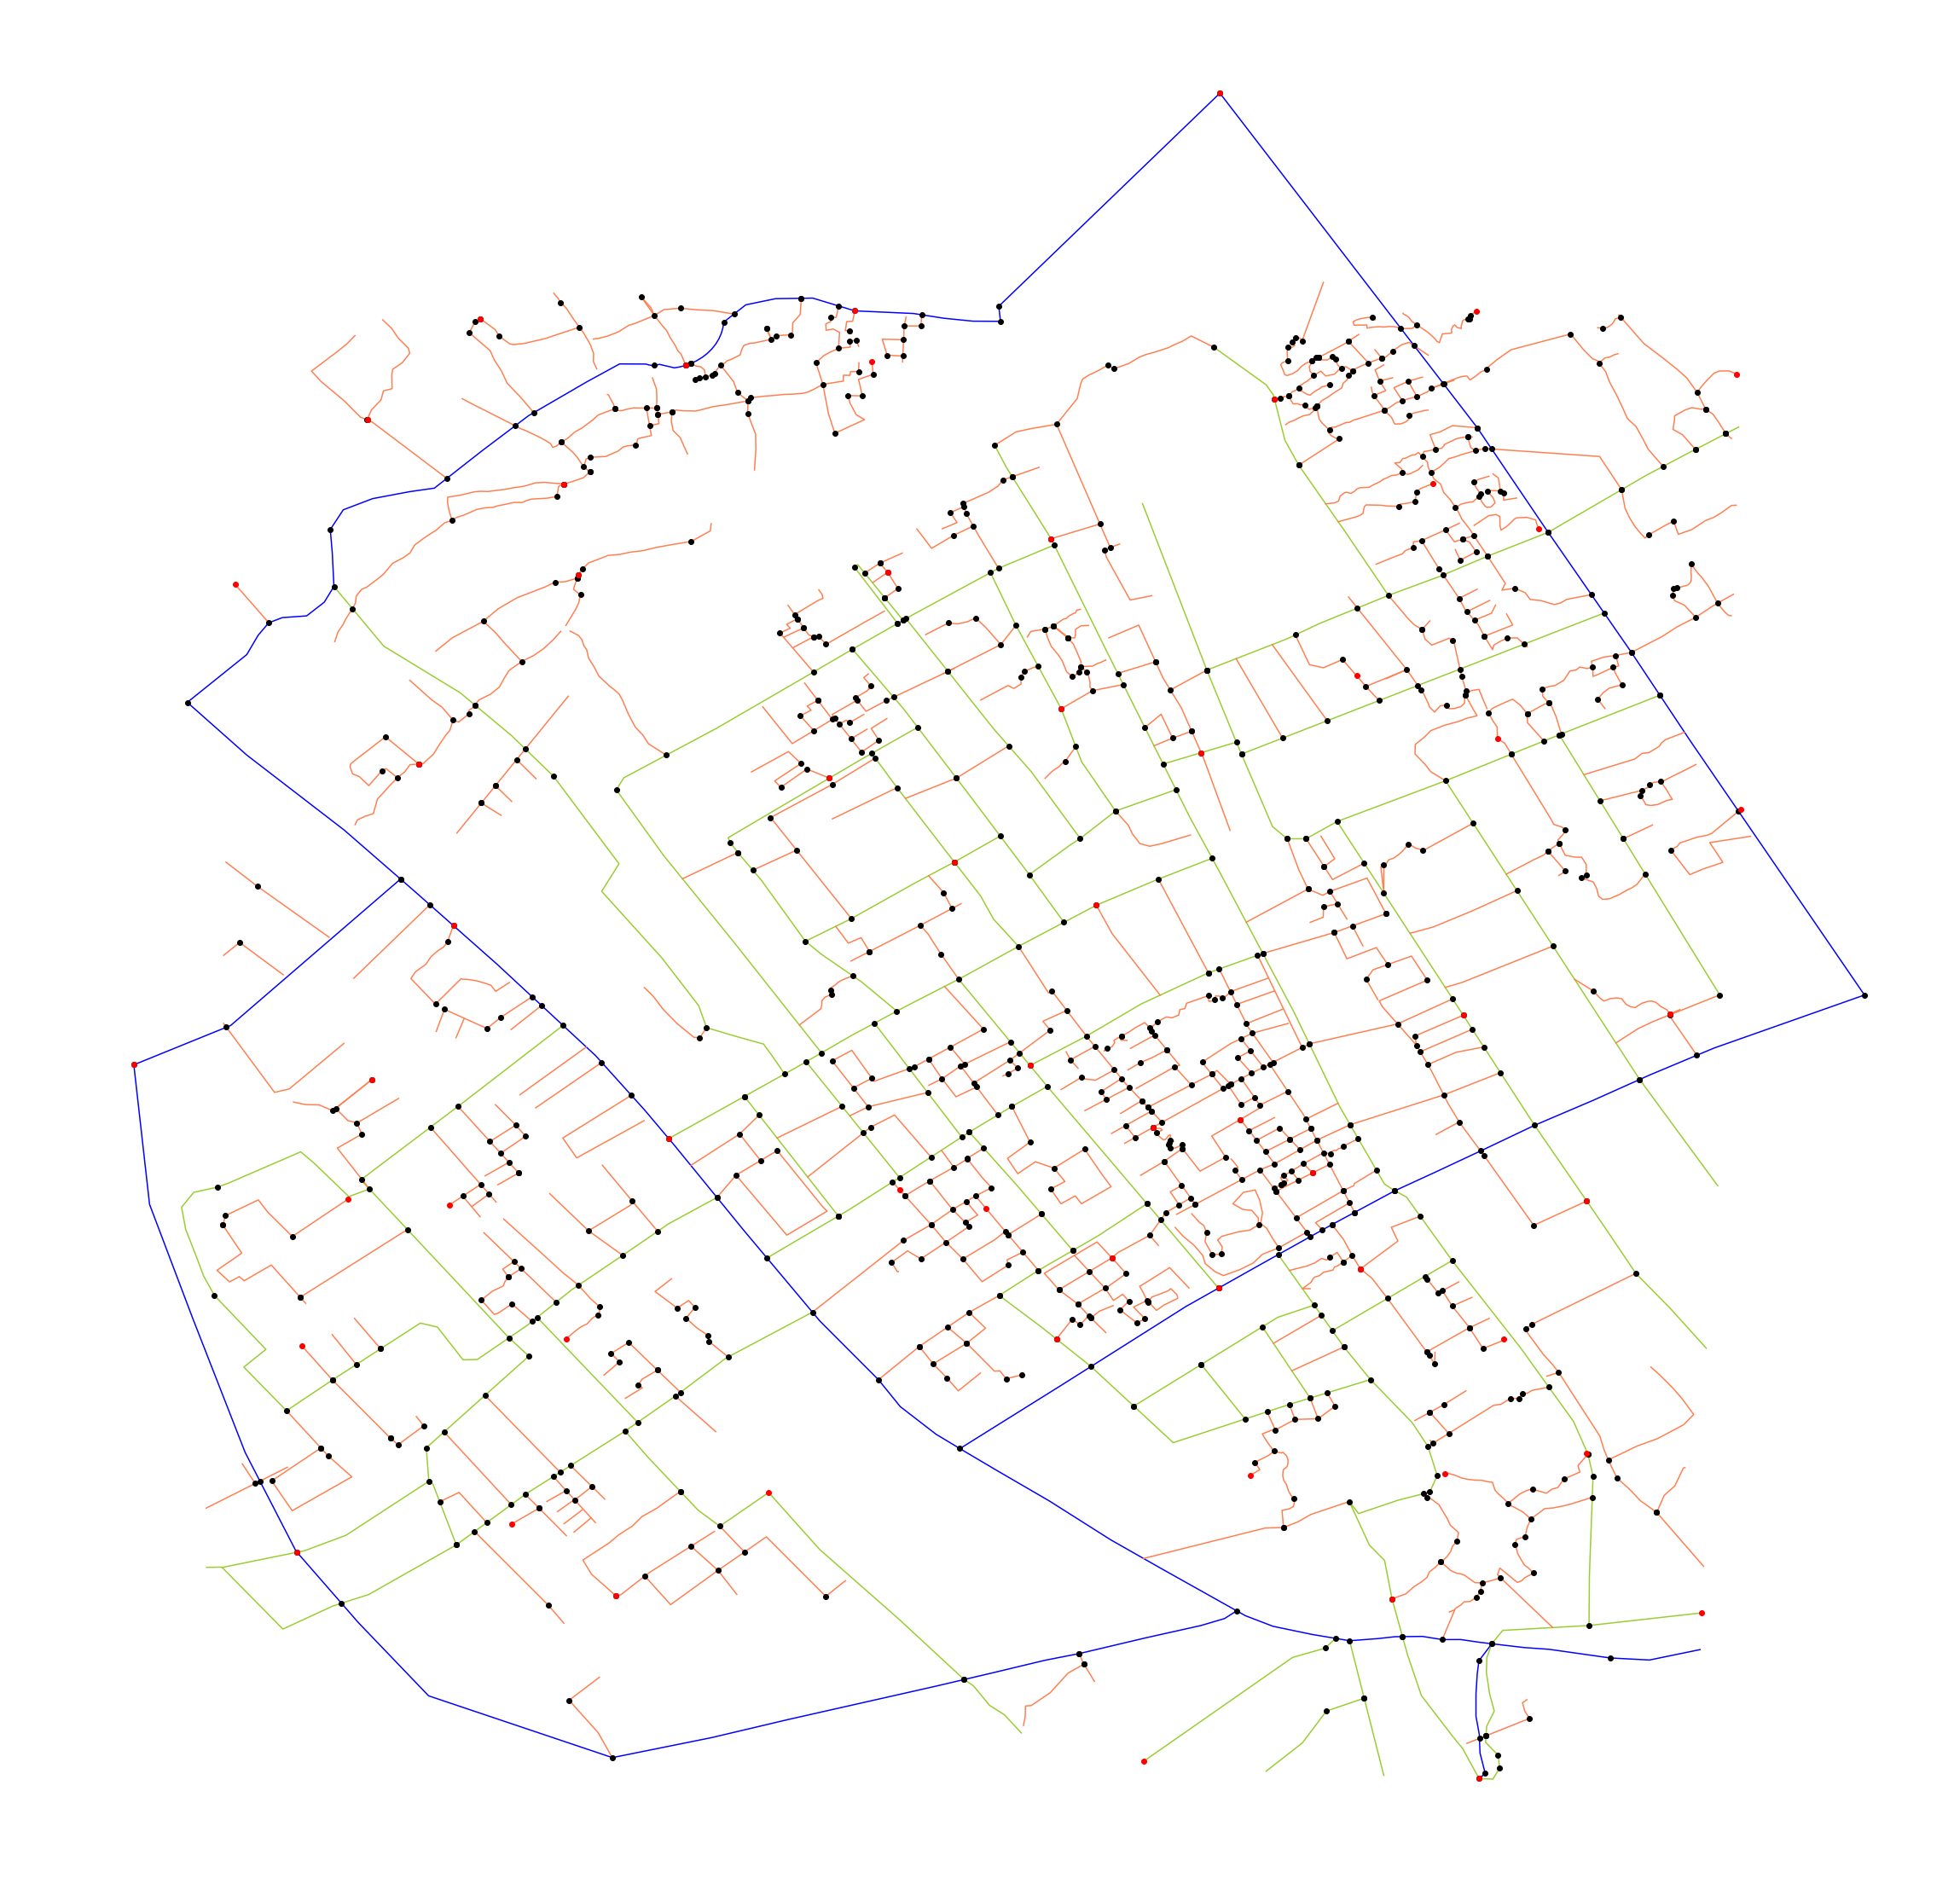

In [11]:
plotIntersections(allRoadsLatLong, allRoadTypes, allVillagesLatLong)

In [35]:
bef = []
for rd in allRoadsLatLong:
    bef.append(len(rd))

In [13]:
for i in range(len(allRoadsLatLong)):
    for j in range(len(newRoadPoints[i])):
        index = [n for n,pt in enumerate(allRoadsLatLong[i]) if pt[0]>newRoadPoints[i][j][0]]
        try:
            allRoadsLatLong[i].insert(index[0]-1,newRoadPoints[i][j])
        except:
            allRoadsLatLong[i].append(newRoadPoints[i][j])

In [14]:
aft = []
for rd in allRoadsLatLong:
    aft.append(len(rd))

In [15]:
sum(bef), sum(aft)

(3351, 7307)